# SOM Kohonen Network

After reading the spec and understanding the problem, optimization is definitely important consideration. I want to strike a balance optimizing too early ("premature optimization is the root of all evil") and accululating technical debt. 

Doing a code profile with cProfile would tell us what the most important functions to optimize (we can consder the 80 20 rule here). 

My approach was to implement the internal SOM functions with vectorized numpy  operations and see what optimizations can be done from there. We can easily use Numba to optimize numpy and multiprocessing if needed.  However, I also do not want to sacrifice readability or maintanability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit, prange

In [2]:
# create test inputs

INPUT_DIM = 3
TEST_INPUT_1 = np.arange(0, INPUT_DIM).reshape((1,-1))
TEST_INPUT_2 = np.arange(1, INPUT_DIM+1)
TEST_INPUT_3 = np.arange(2, INPUT_DIM+2)

In [3]:
MAT_SIZE= (100, 100)

res = np.zeros(MAT_SIZE)
mat = np.random.random((MAT_SIZE[0], MAT_SIZE[1], INPUT_DIM))

## Firstly write and test a few functions

We want to later write these functions into a class, but it is easier to prototype normal functions first. We don't want to spend too much time optimizing here first. But we do want to gauge how much speed up we get from for-loops (optimised by numba/jit), vectorized version, and vectorized version optimized by numba/jit.

We find that using vectorized operation for calculating euclidean dist is obviously faster, but we can get even faster speedups using numba and JIT

In [4]:
@jit(nopython=True)
def calc_bmu_metric(vec_1, vec_2):
    return np.linalg.norm(vec_1 - vec_2)

@jit(nopython=True)
def calc_bmu_matrix_iterative(vec, matrix):
    res=np.zeros((matrix.shape[0], matrix.shape[1]))
    for j in range(matrix.shape[0]):
        for i in range(matrix.shape[1]):
            res[j, i]=calc_bmu_metric(TEST_INPUT_1, matrix[j, i, :])
    return res

In [5]:
%%timeit

calc_bmu_matrix_iterative(TEST_INPUT_1, mat)

5.84 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
def calc_bmu_matrix_vectorised(vec_a, matrix):
    subtracted_mat = np.multiply(np.ones((matrix.shape[0], matrix.shape[1], INPUT_DIM)), TEST_INPUT_1) - matrix
    squared = np.multiply(subtracted_mat, subtracted_mat)
    return np.sqrt(np.sum(squared, axis=-1))

@jit(nopython=True)
def calc_bmu_matrix_vectorised_jit(vec_a, matrix):
    subtracted_mat = np.multiply(np.ones((matrix.shape[0], matrix.shape[1], INPUT_DIM)), TEST_INPUT_1) - matrix
    squared = np.multiply(subtracted_mat, subtracted_mat)
    return np.sqrt(np.sum(squared, axis=-1))

In [7]:
%%timeit
calc_bmu_matrix_vectorised(TEST_INPUT_1, mat)

423 µs ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
calc_bmu_matrix_vectorised_jit(TEST_INPUT_1, mat)

255 µs ± 50.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
np.testing.assert_almost_equal(calc_bmu_matrix_vectorised(TEST_INPUT_1, mat), calc_bmu_matrix_iterative(TEST_INPUT_1, mat))

## Making it a class

After writing more few functions, the code was best placed into a class where it would evenutally reside (I did not want to accumulate technical debt). I also wrote few test cases for some functions for sanity checking purposes. Actually hand calculating SOM iterations with hard coded weights was going to be quite tedious so i skipped out on this...

I did write pytest cases with the idea of running them with python -m pytest in terminal. Please find these in src/test_som.py

My test cases and class looks as follows:

In [11]:
%%writefile src/test_som.py

import numpy as np
from som_network import SomNetwork
from som_network_jit import SomNetworkJit

class TestSom:
    @classmethod
    def setup_class(cls):
        cls.som_5x5 = SomNetwork(map_size=(5, 5), input_dim=3)
        cls.som_20x20 = SomNetwork(map_size=(20, 20), input_dim=3)
        cls.input_vec_1 = np.arange(0, 3).reshape((1, -1))
        cls.input_vec_2 = np.arange(0, 6).reshape((2, -1))

    def test_weights_size(self):
        assert self.som_5x5.weights.shape == (5, 5, 3)

    def test_neighbourhood_mask(self):
        mask = self.som_5x5.get_neighbourhood_mask(point_coord=(1, 1), radius=2)
        mask_gt = np.array([[True, True, True, False, False],
                            [True, True, True, True, False],
                            [True, True, True, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False]])
        np.testing.assert_array_equal(mask, mask_gt)

    def test_bmu_coord(self):
        self.som_20x20.weights[10, 3, :] = np.array([0, 1, 2])
        np.testing.assert_almost_equal(self.som_20x20.get_bmu_coord(self.input_vec_1), (10, 3))

        self.som_20x20.weights[16, 2, :] = np.array([3, 4, 5])
        np.testing.assert_almost_equal(self.som_20x20.get_bmu_coord(self.input_vec_2[1]), (16, 2))

    def test_neighbourhood_radius(self):
        np.testing.assert_array_equal(self.som_20x20.calc_neighbourhood_radius(5, 20),
                                      10 * np.exp(-5 / (20 / np.log(10))))

    def test_learning_rate(self):
        np.testing.assert_array_equal(self.som_20x20.get_learning_rate(5, 20), 0.1 * np.exp(-(5 / (20 / np.log(10)))))

    def test_bmu_matrix(self):
        self.som_5x5.weights = np.zeros((5, 5, 3))

        # Set 0,0 -> [0,1,2] and 3,3 -> 3, 4, 5
        # 3, 3 ->
        self.som_5x5.weights[0, 0, :] = np.array([0, 1, 2])
        self.som_5x5.weights[3, 3, :] = np.array([3, 4, 5])
        answer_array = np.ones((5, 5)) * np.sqrt(np.sum(np.array([0, 1, 4])))
        answer_array[0, 0] = np.sqrt(np.sum(np.array([0, 0, 0])))
        answer_array[3, 3] = np.sqrt(np.sum(np.array([9, 9, 9])))
        np.testing.assert_almost_equal(self.som_5x5.calc_bmu_matrix_vectorised(self.input_vec_1), answer_array)

    def test_influence_matrix(self):
        neighbourhood_radius = 3
        point_coord = (1, 1)
        influence_matrix = self.som_5x5.get_influence_matrix(point_coord, neighbourhood_radius)
        dist_matrix = np.array([[np.sqrt(2), 1, np.sqrt(2), np.sqrt(5), np.sqrt(10)],
                                [1, 0, 1, 2, 3],
                                [np.sqrt(2), 1, np.sqrt(2), np.sqrt(5), np.sqrt(10)],
                                [np.sqrt(5), 2, np.sqrt(5), np.sqrt(8), np.sqrt(13)],
                                [np.sqrt(10), 3, np.sqrt(10), np.sqrt(13), np.sqrt(18)]])
        ans = np.array(np.exp(-np.square(dist_matrix) / (2 * np.square(neighbourhood_radius))))
        np.testing.assert_almost_equal(ans, influence_matrix)

Overwriting src/test_som.py


In [12]:
from tqdm import tqdm
import numpy as np


class SomNetwork:
    def __init__(self, map_size=(10, 10), input_dim=3):
        """Kohonen's Self Organising Map Class.

        This class implements the SOM in a mostly vectorized way in numpy.

        :param map_size (int, int): The size of the weights map of the SOM network
        :param input_dim (int): The dimension of the input vector
        """
        self.weights = np.random.random(size=(map_size[0], map_size[1], input_dim)).astype(np.float64)
        self.init_rad = max(map_size[0], map_size[1]) / 2
        self.init_learning_rate = 0.1
        self.fitted = False

    def calc_bmu_matrix_vectorised(self, vec_a):
        """Calculates the BMU euclidean distance from the input vector for each node on the SOM map.

        :param vec_a (np.array): The input vector vec_a
        :return: np.array matrix for the euclidean distance from the input vector for each node on the SOM map
        """
        subtracted_mat = np.multiply(
            np.ones((self.weights.shape[0], self.weights.shape[1], self.weights.shape[2])), vec_a) - self.weights
        squared = np.multiply(subtracted_mat, subtracted_mat)
        return np.sqrt(np.sum(squared, axis=-1))

    def get_bmu_coord(self, vec_a):
        """Gets the BMU coord from the self.weights matrix based on the input vector vec_a

        :param vec_a (np.array):
        :return: (int, int) coordinates of the BMU of the SOM weights
        """
        bmu_matrix = self.calc_bmu_matrix_vectorised(vec_a)
        # Returns the flattened argmin index
        bmu_index = np.argmin(bmu_matrix, axis=None)
        # Need to get the 0th and 1st indexes from the flattened
        bmu_index_0 = bmu_index // self.weights.shape[0]
        bmu_index_1 = bmu_index % self.weights.shape[0]
        return (bmu_index_0, bmu_index_1)

    def get_time_const(self, n_iterations):
        """Calculates the time const based on the iteration number"""
        return n_iterations / np.log(self.init_rad)

    def calc_neighbourhood_radius(self, iteration_no, n_iterations):
        """ Calculates the the neighbourhood radius

        :param iteration_no (int): The iteration number
        :param n_iterations (int): the number of iterations
        :return: float of neighbourhood radius
        """
        return self.init_rad * np.exp(-(iteration_no / self.get_time_const(n_iterations)))

    def get_neighbourhood_mask(self, point_coord, radius):
        """ Gets the neighbour radius mask for a speicifed point_coord

        :param point_coord tuple(int,int): the center coordinates to get the neighbour radius from
        :param radius: the radius to get the mask from
        :return: np.array binary mask of points which are True for radius dist away from point_coord
        """
        y, x = np.ogrid[-point_coord[0]:self.weights.shape[0] - point_coord[0],
               -point_coord[1]:self.weights.shape[1] - point_coord[1]]
        mask = x * x + y * y <= radius * radius
        return mask

    def get_learning_rate(self, iteration_no, n_iterations):
        """ Returns the learning rate from the iteration_no and n_iterations

        :param iteration_no(int): The iteration number
        :param n_iterations(int): The number of iterations
        :return: float of the learning rate
        """
        return self.init_learning_rate * np.exp(-(iteration_no / self.get_time_const(n_iterations)))

    def get_influence_matrix(self, point_coord, neighbourhood_radius):
        """Calculates and returns the influence matrix from a specified point_coord and neighbourhood radius

        :param point_coord(tuple(int, int)): the point coordinates to calculate the influence matrix from
        :param neighbourhood_radius (int): the neighbourhood radius
        :return: np.array of the influence numbers for each point in the matrix
        """
        index_matrix = np.indices((self.weights.shape[0], self.weights.shape[1]))
        influence_matrix = np.square(point_coord[0] - index_matrix[0]) + np.square(point_coord[1] - index_matrix[1])
        return np.exp(-(influence_matrix / (2 * np.square(neighbourhood_radius))))

    def update_weights(self, input_vec, iteration_no, n_iterations):
        """ Update the weights according to Kohonen's map. A binary mask is used mask out all elements outside the
        neighbourhood radius. This is multiplied by the influence matrix so that any elements outside the radius are
        unaffected by the weight updates.

        :param input_vec (np.array dim=1): the input vector
        :param iteration_no (int): the iteration number
        :param n_iterations (int): the total number of iterations
        :return: the weights matrix
        """
        bmu_coord = self.get_bmu_coord(input_vec)
        radius = self.calc_neighbourhood_radius(iteration_no, n_iterations)

        # We can use the mask times the influence matrix to set the new weights. Zero'd influence means no change
        mask = self.get_neighbourhood_mask(bmu_coord, radius).astype(int)
        influence_masked = self.get_influence_matrix(bmu_coord, radius)
        subtracted_mat = np.multiply(np.ones((self.weights.shape[0], self.weights.shape[1], self.weights.shape[2])),
                                     input_vec) - self.weights
        lr_mult_influence_mask = np.multiply(self.get_learning_rate(iteration_no, n_iterations),
                                             influence_masked[:, :, None])
        second_term = np.multiply(lr_mult_influence_mask, subtracted_mat)
        self.weights = np.add(self.weights, second_term)

    def fit(self, input_matrix, n_iterations):
        """Fit the weights of the SOM network by iteratively looping through the matrix row by row for n_iterations.

        :param input_matrix (np.array): input matrix
        :param n_iterations (int): The number of iterations
        :return: np.array of the fitted SOM weights
        """

        assert not self.fitted, 'SOM has already been fitted'

        # iterate through each input vector
        for iteration_no in tqdm(range(n_iterations)):
            for input_vector in input_matrix:
                self.update_weights(input_vector, iteration_no, n_iterations)
        self.fitted = True
        return self.weights

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 231.46it/s]


Wall time: 469 ms


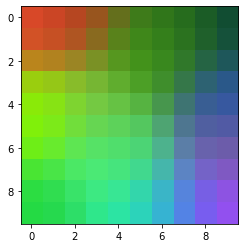

In [13]:
%%time

test_mat = np.random.random((20, 3))
som = SomNetwork(map_size=(10, 10), input_dim=3)
weights = som.fit(test_mat, 100)
plt.imshow(weights)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.78it/s]


Wall time: 31.5 s


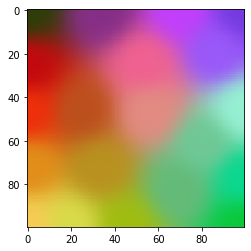

In [14]:
%%time

test_mat = np.random.random((20,3))
som = SomNetwork(map_size=(100, 100), input_dim=3)
weights = som.fit(test_mat, 1000)
plt.imshow(weights)

## Code Profiling

From our following code profile, the following functions take all the time most the time comes from :

    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    2.838    0.000   10.715    0.001 <ipython-input-11-548778fac8c1>:89(update_weights)
    10000    0.065    0.000    3.829    0.000 <ipython-input-11-548778fac8c1>:30(get_bmu_coord)
    10000    1.384    0.000    3.582    0.000 <ipython-input-11-548778fac8c1>:19(calc_bmu_matrix_vectorised)
    10000    2.246    0.000    2.510    0.000 <ipython-input-11-548778fac8c1>:78(get_influence_matrix)
    
    
The calc_bmu_matrix_vectorized and get_influence_matrix functions are all run within the update_weights function. These two functions account for 54% of the cpu time. Optimizing this would be hugely beneficial

In [18]:
%%prun -s cumulative

test_mat = np.random.random((20,3))
som = SomNetwork(map_size=(100, 100), input_dim=3)
weights = som.fit(test_mat, 1000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.86it/s]


         1171398 function calls (1171397 primitive calls) in 33.495 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   33.495   33.495 {built-in method builtins.exec}
        1    0.000    0.000   33.495   33.495 <string>:1(<module>)
        1    0.140    0.140   33.494   33.494 <ipython-input-12-548778fac8c1>:112(fit)
    20000    8.410    0.000   32.802    0.002 <ipython-input-12-548778fac8c1>:89(update_weights)
    20000    0.221    0.000   11.850    0.001 <ipython-input-12-548778fac8c1>:30(get_bmu_coord)
    20000    4.474    0.000   11.064    0.001 <ipython-input-12-548778fac8c1>:19(calc_bmu_matrix_vectorised)
    20000    6.968    0.000    7.753    0.000 <ipython-input-12-548778fac8c1>:78(get_influence_matrix)
    20000    0.109    0.000    6.125    0.000 fromnumeric.py:1966(sum)
    20000    0.135    0.000    5.994    0.000 fromnumeric.py:69(_wrapreduction)
    20000    5.813    0.000    

### Attempt at optimizing with Numba JIT

With our first scenario, it is obvious that Numba and JIT provide good speedups to numpy. Implementing it for an application can be tricky though.

I first attempted to optimize making the whole class a jitclass but this proved way too time consuming and involved many code changes. A hacky workaround is to make the functions to optimize a static method. However, this method makes code more messy, as we cannot directly access self instsance variables. There are also a few changes to make it compatible from Numba.

I've opted to optimise calc_bmu_matrix_vectorised and get_influence_matrix functions as these contribute the most and is the easiest to change.

In [19]:
from tqdm import tqdm
import numpy as np
from numba import jit


class SomNetworkJit:
    def __init__(self, map_size=(10, 10), input_dim=3):
        """Kohonen's Self Organising Map Class.

        This class implements the SOM in a mostly vectorized way in numpy.

        :param map_size (int, int): The size of the weights map of the SOM network
        :param input_dim (int): The dimension of the input vector
        """
        self.weights = np.random.random(size=(map_size[0], map_size[1], input_dim)).astype(np.float64)
        self.init_rad = max(map_size[0], map_size[1]) / 2
        self.init_learning_rate = 0.1
        self.fitted = False

    @staticmethod
    @jit(nopython=True, parallel=False)
    def calc_bmu_matrix_vectorised(matrix, vec_a):
        """Calculates the BMU euclidean distance from the input vector for each node on the SOM map.

        :param vec_a (np.array): The input vector vec_a
        :return: np.array matrix for the euclidean distance from the input vector for each node on the SOM map
        """
        subtracted_mat = np.multiply(np.ones((matrix.shape[0], matrix.shape[1], matrix.shape[2])), vec_a) - matrix
        squared = np.multiply(subtracted_mat, subtracted_mat)
        return np.sqrt(np.sum(squared, axis=-1))

    def get_bmu_coord(self, vec_a):
        """Gets the BMU coord from the self.weights matrix based on the input vector vec_a

        :param vec_a (np.array):
        :return: (int, int) coordinates of the BMU of the SOM weights
        """
        bmu_matrix = self.calc_bmu_matrix_vectorised(self.weights, vec_a)
        # Returns the flattened argmin index
        bmu_index = np.argmin(bmu_matrix, axis=None)
        # Need to get the 0th and 1st indexes from the flattened
        bmu_index_0 = bmu_index // self.weights.shape[0]
        bmu_index_1 = bmu_index % self.weights.shape[0]
        return (bmu_index_0, bmu_index_1)

    def get_time_const(self, n_iterations):
        """Calculates the time const based on the iteration number"""
        return n_iterations / np.log(self.init_rad)

    def calc_neighbourhood_radius(self, iteration_no, n_iterations):
        """ Calculates the the neighbourhood radius

        :param iteration_no (int): The iteration number
        :param n_iterations (int): the number of iterations
        :return: float of neighbourhood radius
        """
        return self.init_rad * np.exp(-(iteration_no / self.get_time_const(n_iterations)))

    def get_neighbourhood_mask(self, point_coord, radius):
        """ Gets the neighbour radius mask for a speicifed point_coord

        :param point_coord tuple(int,int): the center coordinates to get the neighbour radius from
        :param radius: the radius to get the mask from
        :return: np.array binary mask of points which are True for radius dist away from point_coord
        """
        y, x = np.ogrid[-point_coord[0]:self.weights.shape[0] - point_coord[0],
               -point_coord[1]:self.weights.shape[1] - point_coord[1]]
        mask = x * x + y * y <= radius * radius
        return mask

    def get_learning_rate(self, iteration_no, n_iterations):
        """ Returns the learning rate from the iteration_no and n_iterations

        :param iteration_no(int): The iteration number
        :param n_iterations(int): The number of iterations
        :return: float of the learning rate
        """
        return self.init_learning_rate * np.exp(-(iteration_no / self.get_time_const(n_iterations)))

    @staticmethod
    @jit(nopython=True)
    def get_influence_matrix(matrix, point_coord, neighbourhood_radius):
        """Calculates and returns the influence matrix from a specified point_coord and neighbourhood radius

        :param point_coord(tuple(int, int)): the point coordinates to calculate the influence matrix from
        :param neighbourhood_radius (int): the neighbourhood radius
        :return: np.array of the influence numbers for each point in the matrix
        """
        influence_matrix = np.zeros((matrix.shape[0], matrix.shape[1]))
        # Create index matrix
        indices = np.zeros((2, matrix.shape[0], matrix.shape[1]))
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                indices[1, i, j] = j
                indices[0, i, j] = i
        indices = indices.astype(np.int32)
        influence_matrix = np.square(point_coord[0] - indices[0]) + np.square(point_coord[1] - indices[1])
        return np.exp(-(influence_matrix / (2 * np.square(neighbourhood_radius))))

    def update_weights(self, input_vec, iteration_no, n_iterations):
        """ Update the weights according to Kohonen's map. A binary mask is used mask out all elements outside the
        neighbourhood radius. This is multiplied by the influence matrix so that any elements outside the radius are
        unaffected by the weight updates.

        :param input_vec (np.array dim=1): the input vector
        :param iteration_no (int): the iteration number
        :param n_iterations (int): the total number of iterations
        :return: the weights matrix
        """
        bmu_coord = self.get_bmu_coord(input_vec)
        radius = self.calc_neighbourhood_radius(iteration_no, n_iterations)

        # We can use the mask times the influence matrix to set the new weights. Zero'd influence means no change
        mask = self.get_neighbourhood_mask(bmu_coord, radius).astype(int)
        influence_masked = self.get_influence_matrix(self.weights, bmu_coord, radius)
        subtracted_mat = np.multiply(np.ones((self.weights.shape[0], self.weights.shape[1], self.weights.shape[2])),
                                     input_vec) - self.weights
        lr_mult_influence_mask = np.multiply(self.get_learning_rate(iteration_no, n_iterations),
                                             influence_masked[:, :, None])
        second_term = np.multiply(lr_mult_influence_mask, subtracted_mat)
        self.weights = np.add(self.weights, second_term)

    def fit(self, input_matrix, n_iterations):
        """Fit the weights of the SOM network by iteratively looping through the matrix row by row for n_iterations.

        :param input_matrix (np.array): input matrix
        :param n_iterations (int): The number of iterations
        :return: np.array of the fitted SOM weights
        """

        assert not self.fitted, 'SOM has already been fitted'

        # iterate through each input vector
        for iteration_no in tqdm(range(n_iterations)):
            for input_vector in input_matrix:
                self.update_weights(input_vector, iteration_no, n_iterations)
        self.fitted = True
        return self.weights


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.92it/s]


Wall time: 29.5 s


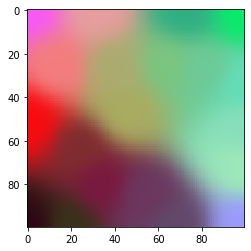

In [20]:
%%time

test_mat = np.random.random((20,3))
som = SomNetworkJit(map_size=(100, 100), input_dim=3)
weights = som.fit(test_mat, 1000)
plt.imshow(weights)

## We decreased the time from 33.50s to 29.5s.

We can further decrease if we can do the .fit loop in batches instead of per row vector and update the weights per batch.

## Test cases for Numba JIT version. 

We use the results from the SomNetwork normal version for an easy way to test, as those results are already tested.

In [21]:
# %%writefile src/test_som.py -a


class TestSomJit:
    @classmethod
    def setup_class(cls):
        cls.som_5x5 = SomNetworkJit(map_size=(5, 5), input_dim=3)
        cls.som_5x5_slow = SomNetwork(map_size=(5, 5), input_dim=3)

        cls.som_20x20 = SomNetworkJit(map_size=(20, 20), input_dim=3)
        cls.som_20x0_slow = SomNetwork(map_size=(5, 5), input_dim=3)

        cls.som_20x20 = SomNetworkJit(map_size=(20, 20), input_dim=3)
        cls.som_20x20_slow = SomNetwork(map_size=(5, 5), input_dim=3)

        cls.som_100x100 = SomNetworkJit(map_size=(20, 20), input_dim=3)
        cls.som_100x100_small = SomNetwork(map_size=(20, 20), input_dim=3)

        cls.input_vec_1 = np.arange(0, 3).reshape((1, -1))
        cls.input_vec_2 = np.arange(0, 6).reshape((2, -1))

    def test_weights_size(self):
        assert self.som_5x5.weights.shape == (5, 5, 3)

    def test_neighbourhood_mask(self):
        mask = self.som_5x5.get_neighbourhood_mask(point_coord=(1, 1), radius=2)
        mask_gt = np.array([[True, True, True, False, False],
                            [True, True, True, True, False],
                            [True, True, True, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False]])
        np.testing.assert_array_equal(mask, mask_gt)

    def test_bmu_coord(self):
        self.som_20x20.weights[3, 3, :] = np.array([0, 1, 2])
        np.testing.assert_almost_equal(self.som_20x20.get_bmu_coord(self.input_vec_1), (3, 3))

    # We can compare that the fitting logic is the same as the original implementation
    def compare_with_slow_small(self):
        # set the weights the same
        self.som_5x5.weights = self.som_5x5_slow.weights
        slow = self.som_5x5.fit(input_matrix=self.input_vec_1, n_iterations=5)
        jit = self.som_5x5_slow.fit(input_matrix=self.input_vec_1, n_iterations=5)
        np.test.assert_almost_equal(slow, jit)

    def compare_with_slow_big(self):
        # set the weights the same
        self.som_20x20.weights = self.som_20x20_slow.weights
        slow = self.som_20x20.fit(input_matrix=self.input_vec_1, n_iterations=100)
        jit = self.som_20x20_slow.fit(input_matrix=self.input_vec_1, n_iterations=100)
        np.test.assert_almost_equal(slow, jit)

        self.som_100x100.weights = self.som_100x100_small.weights
        slow = self.som_100x100.fit(input_matrix=self.input_vec_1, n_iterations=100)
        jit = self.som_100x100_slow.fit(input_matrix=self.input_vec_1, n_iterations=100)
        np.test.assert_almost_equal(slow, jit)


## We've basically productionized the model already, here's how to use it as a API

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.23it/s]


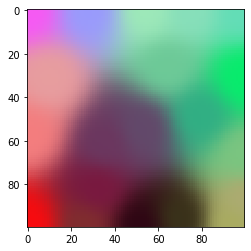

In [22]:
from src.som_network_jit import SomNetworkJit

som = SomNetworkJit(map_size=(100, 100), input_dim=3)
weights = som.fit(test_mat, 1000)
plt.imshow(weights)

## Unit tests can be run with python -m pytest from the same directory this notebook resides in.